In [1]:
import kagglehub
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import random
import spacy
from tqdm import tqdm
import seaborn as sns
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#nltk.download('punkt_tab')

# Data Import

In [2]:
# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/solomongreene/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


Here I used a mv command in the terminal to move them both to a folder named data

In [3]:
# import fake csv
file_path = 'data/Fake.csv'
fake_data = pd.read_csv(file_path)

# testing import 
print(fake_data.iloc[0]['text'])
fake_data.head()

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# import true csv
true_path = 'data/True.csv'
true_data = pd.read_csv(true_path)

In [5]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [7]:
true_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


we have an uneven balance of data. we will need to correct for this eventually. 

# Data Pre-processing

In [8]:
# Add a new column 'label' to fake and true dataframe, then combine
fake_data['label'] = 0  # 0 for fake data
true_data['label'] = 1  # 1 for true data

combined_data = pd.concat([fake_data, true_data], ignore_index=True)

print(combined_data[['text', 'label']].head())

                                                text  label
0  Donald Trump just couldn t wish all Americans ...      0
1  House Intelligence Committee Chairman Devin Nu...      0
2  On Friday, it was revealed that former Milwauk...      0
3  On Christmas day, Donald Trump announced that ...      0
4  Pope Francis used his annual Christmas Day mes...      0


## Tokenize text

In [9]:
# tokenize into new column 'text_tokenized'
combined_data['text_tokenized'] = combined_data['text'].apply(word_tokenize)

In [10]:
combined_data.head()

,title,text,subject,date,label,text_tokenized
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,"[Donald, Trump, just, couldn, t, wish, all, Am..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,"[House, Intelligence, Committee, Chairman, Dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,"[On, Friday, ,, it, was, revealed, that, forme..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,"[On, Christmas, day, ,, Donald, Trump, announc..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,"[Pope, Francis, used, his, annual, Christmas, ..."


In [11]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           44898 non-null  object
 1   text            44898 non-null  object
 2   subject         44898 non-null  object
 3   date            44898 non-null  object
 4   label           44898 non-null  int64 
 5   text_tokenized  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


## Filter for Stopwords

In [12]:
# filter for stopwords and non-words into new column 'text_tokenized_filtered'
stop_words = set(stopwords.words("english"))

def filter_tokens(tokens):
    return [word for word in tokens if word.casefold() not in stop_words and word.isalpha()]

combined_data['text_tokenized_filtered'] = combined_data['text_tokenized'].apply(filter_tokens)

In [13]:
combined_data.head()

,title,text,subject,date,label,text_tokenized,text_tokenized_filtered
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,"[Donald, Trump, just, couldn, t, wish, all, Am...","[Donald, Trump, wish, Americans, Happy, New, Y..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,"[House, Intelligence, Committee, Chairman, Dev...","[House, Intelligence, Committee, Chairman, Dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,"[On, Friday, ,, it, was, revealed, that, forme...","[Friday, revealed, former, Milwaukee, Sheriff,..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,"[On, Christmas, day, ,, Donald, Trump, announc...","[Christmas, day, Donald, Trump, announced, wou..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,"[Pope, Francis, used, his, annual, Christmas, ...","[Pope, Francis, used, annual, Christmas, Day, ..."


In [14]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    44898 non-null  object
 1   text                     44898 non-null  object
 2   subject                  44898 non-null  object
 3   date                     44898 non-null  object
 4   label                    44898 non-null  int64 
 5   text_tokenized           44898 non-null  object
 6   text_tokenized_filtered  44898 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


## Balance Classes

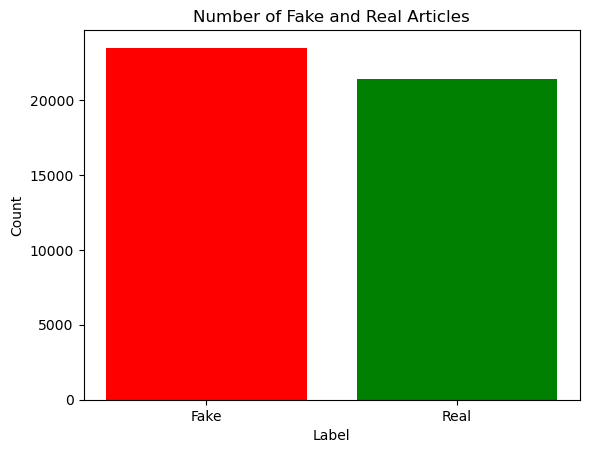

Total Fake Articles: 23481 (52.30%)
Total Real Articles: 21417 (47.70%)


In [15]:
# count occurances of fake and true data and plot
fake_count = len(fake_data)
real_count = len(true_data)
total_articles = len(combined_data)

plt.bar(['Fake', 'Real'], [fake_count, real_count], color=['red', 'green'])
plt.title('Number of Fake and Real Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Print totals and percentages
fake_percentage = (fake_count / total_articles) * 100
real_percentage = (real_count / total_articles) * 100
print(f"Total Fake Articles: {fake_count} ({fake_percentage:.2f}%)")
print(f"Total Real Articles: {real_count} ({real_percentage:.2f}%)")

Our limiting factor is the true articles, so we will randomly sample 21417 fake articles to have even distribution 

In [16]:
fake_data_subset = combined_data[combined_data['label'] == 0].sample(n=real_count, random_state=42)

combined_data = pd.concat([combined_data[combined_data['label'] == 1], fake_data_subset], ignore_index=True)

# Display counts
print(combined_data['label'].value_counts())

label
1    21417
0    21417
Name: count, dtype: int64


## Final pre-processing

Here we will convert all tokenized words to lowercase and remove a set of stopwords we manually specify

In [17]:
combined_data['text_tokenized_filtered'] = combined_data['text_tokenized_filtered'].apply(
    lambda x: [word.lower() for word in x]
)

manual_stopwords = ['reuters', 'reuters.com', 'reutersnews', 'reutersnews.com']

combined_data['text_tokenized_filtered'] = combined_data['text_tokenized_filtered'].apply(
    lambda x: [word.lower() for word in x if not any(word.startswith(stopword) for stopword in manual_stopwords)]
)

In [18]:
combined_data

,title,text,subject,date,label,text_tokenized,text_tokenized_filtered
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"[WASHINGTON, (, Reuters, ), -, The, head, of, ...","[washington, head, conservative, republican, f..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,"[WASHINGTON, (, Reuters, ), -, Transgender, pe...","[washington, transgender, people, allowed, fir..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,"[WASHINGTON, (, Reuters, ), -, The, special, c...","[washington, special, counsel, investigation, ..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,"[WASHINGTON, (, Reuters, ), -, Trump, campaign...","[washington, trump, campaign, adviser, george,..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,"[SEATTLE/WASHINGTON, (, Reuters, ), -, Preside...","[president, donald, trump, called, postal, ser..."
...,...,...,...,...,...,...,...
42829,The Rolling Stones Are DONE With Trump Using ...,The Rolling Stones are now on a growing list o...,News,"May 4, 2016",0,"[The, Rolling, Stones, are, now, on, a, growin...","[rolling, stones, growing, list, rock, stars, ..."
42830,Trump Goes DISGUSTINGLY Low With Assault On H...,"During the first presidential debate, Donald T...",News,"September 29, 2016",0,"[During, the, first, presidential, debate, ,, ...","[first, presidential, debate, donald, trump, t..."
42831,TRANSGENDER PRISONER IN CA JAIL FOR MURDER IS ...,Just when you find yourself wondering if the w...,left-news,"Aug 11, 2015",0,"[Just, when, you, find, yourself, wondering, i...","[find, wondering, world, gone, completely, mad..."
42832,Red Cross Raises Tens Of Millions And You Won...,Americans are opening their wallets and donati...,News,"September 9, 2017",0,"[Americans, are, opening, their, wallets, and,...","[americans, opening, wallets, donating, relief..."


# Statistical Analysis

We will start by seeing if there is a bias towards certain types of words with Named Entity Recognition

In [19]:
spacy.cli.download('en_core_web_sm')  
NER = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
# Randomly sample 5000 fake and 5000 true articles (full dataset took too long to process)
sampled_fake = combined_data[combined_data['label'] == 0].sample(5000, random_state=42)
sampled_true = combined_data[combined_data['label'] == 1].sample(5000, random_state=42)

sampled_data = pd.concat([sampled_fake, sampled_true]).reset_index(drop=True)

In [21]:
# Function to count locations and people
def count_entities(text):
    doc = NER(" ".join(text))
    people = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
    locations = sum(1 for ent in doc.ents if ent.label_ == "GPE")
    return people, locations

entity_counts = sampled_data['text_tokenized_filtered'].apply(count_entities)

sampled_data['person_count'] = [count[0] for count in entity_counts]
sampled_data['location_count'] = [count[1] for count in entity_counts]

sampled_data.head()

,title,text,subject,date,label,text_tokenized,text_tokenized_filtered,person_count,location_count
0,WATCH YOUNG TEENAGE THUGS AS THEY ROB FEMALE R...,Because nothing says justice for Freddie Gra...,left-news,"Apr 26, 2015",0,"[Because, nothing, says, justice, for, Freddie...","[nothing, says, justice, freddie, gray, like, ...",0,2
1,OBAMA RACES TO SET GITMO TERRORISTS FREE…Leave...,It s hard to imagine a President who could be ...,Government News,"Mar 21, 2016",0,"[It, s, hard, to, imagine, a, President, who, ...","[hard, imagine, president, could, barack, huss...",7,13
2,HANNITY TEARS IT UP IN HIS BEST EVER RANT: ‘Hi...,Sean Hannity was on fire with his opening comm...,politics,"Oct 18, 2017",0,"[Sean, Hannity, was, on, fire, with, his, open...","[sean, hannity, fire, opening, comments, one, ...",33,22
3,Trump Campaign Issues Grossly Racist Statemen...,"The Trump campaign is definitely a racist one,...",News,"September 16, 2016",0,"[The, Trump, campaign, is, definitely, a, raci...","[trump, campaign, definitely, racist, one, guy...",9,1
4,BOOM! FBI DIRECTOR CALLS HILLARY Out After She...,"It s not shocking that Hillary s lying again, ...",politics,"May 11, 2016",0,"[It, s, not, shocking, that, Hillary, s, lying...","[shocking, hillary, lying, probably, good, ide...",3,0


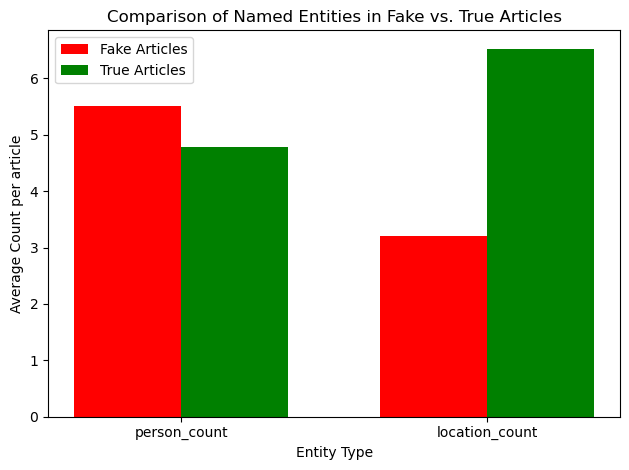

In [22]:
# Create graphs for people and locations found by NER
fake_stats = sampled_data[sampled_data['label'] == 0][['person_count', 'location_count']].mean()
true_stats = sampled_data[sampled_data['label'] == 1][['person_count', 'location_count']].mean()

categories = ['person_count', 'location_count']
fake_means = [fake_stats[cat] for cat in categories]
true_means = [true_stats[cat] for cat in categories]

x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, fake_means, width, label='Fake Articles', color='red')
ax.bar(x + width/2, true_means, width, label='True Articles', color='green')
ax.set_xlabel('Entity Type')
ax.set_ylabel('Average Count per article')
ax.set_title('Comparison of Named Entities in Fake vs. True Articles')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.tight_layout()
plt.show()

Now we will analyze the most frequent words that appear in fake and true articles and see if there is significant overlap or if there are unique words to each class.

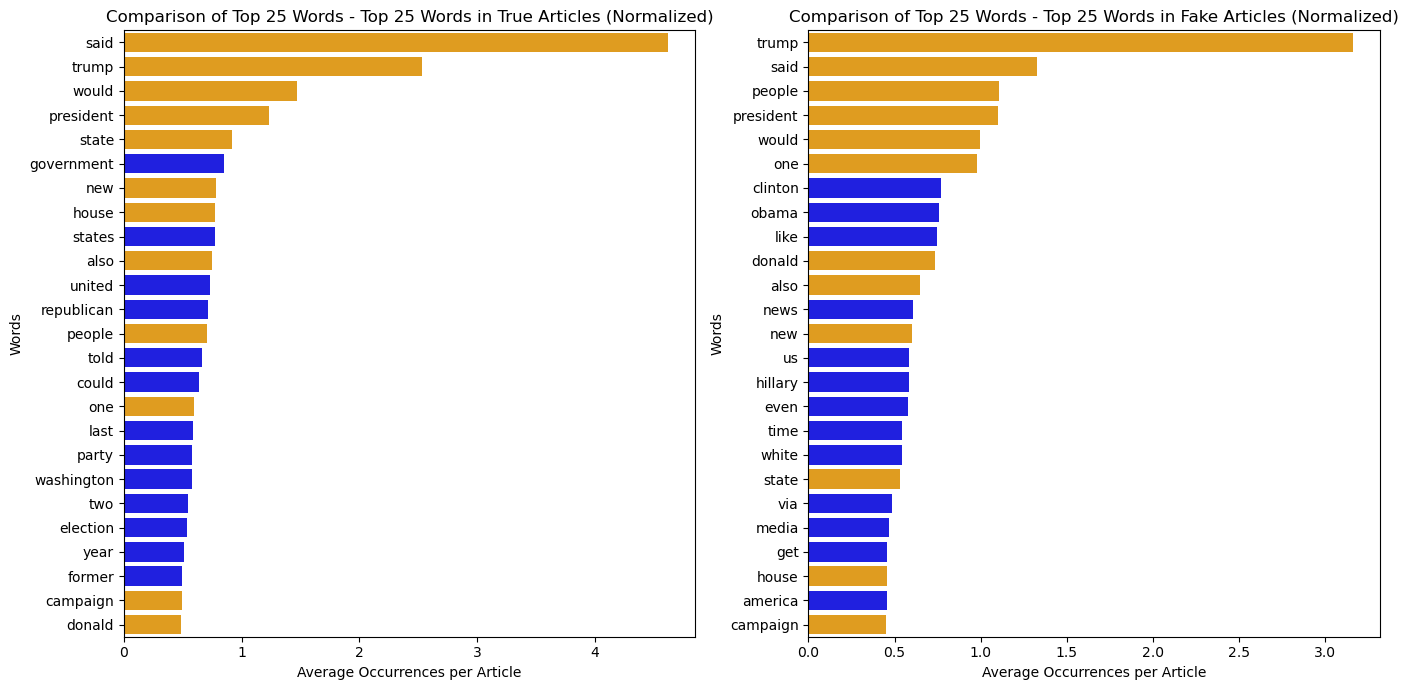

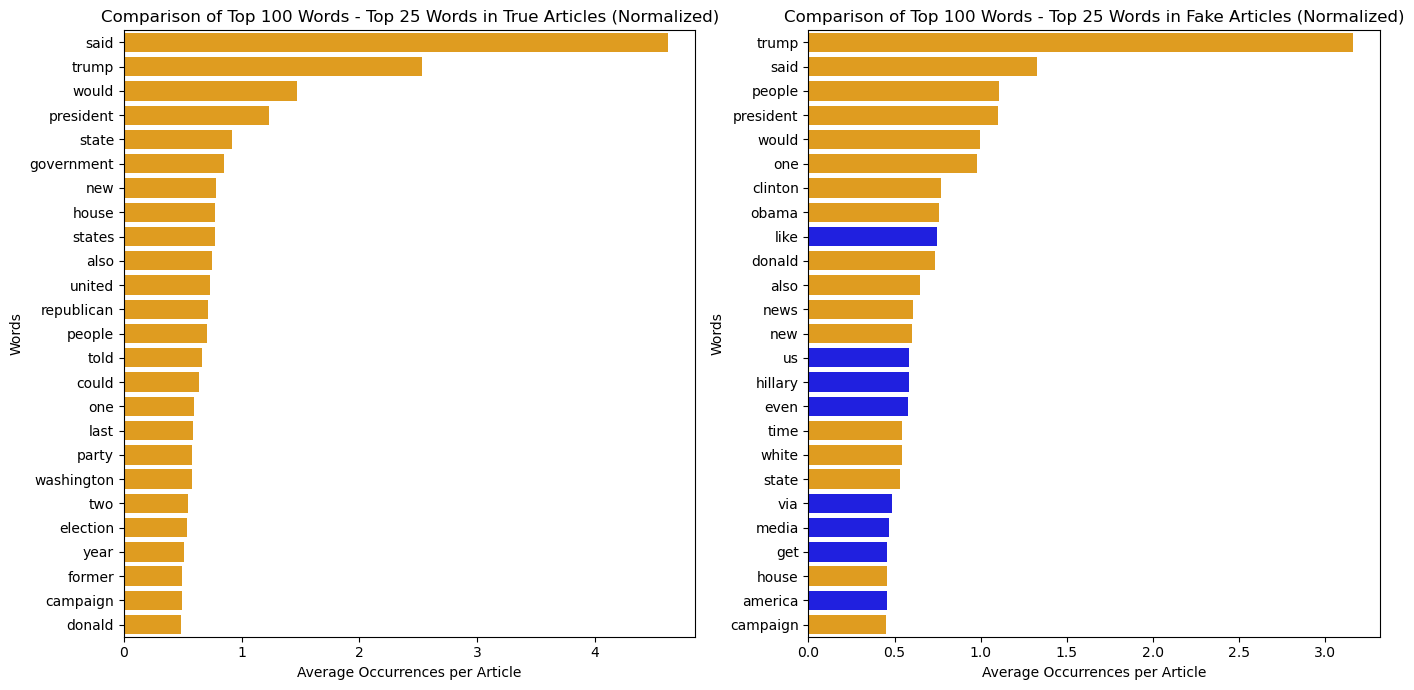

In [23]:
# Separate tokenized words by label then find top 25/top 100. find intersection of sets for overlap and graph
true_words = [word for tokens in combined_data[combined_data['label'] == 1]['text_tokenized_filtered'] for word in tokens]
fake_words = [word for tokens in combined_data[combined_data['label'] == 0]['text_tokenized_filtered'] for word in tokens]

true_word_counts = Counter(true_words)
fake_word_counts = Counter(fake_words)


def graph_common_words(num_depth, base_title):
    true_top_25 = true_word_counts.most_common(num_depth)
    fake_top_25 = fake_word_counts.most_common(num_depth)
    
    true_top_25_dict = dict(true_top_25)
    fake_top_25_dict = dict(fake_top_25)
    
    common_words = set(true_top_25_dict.keys()).intersection(fake_top_25_dict.keys())
    
    def prepare_data_for_plot(top_words, common_words):
        words, counts, colors = [], [], []
        for word, count in top_words:
            words.append(word)
            counts.append(count)
            colors.append('orange' if word in common_words else 'blue')
        return words, counts, colors
    
    # graph by average number of occurances per article
    def average_word_occurrence(word_counts, num_articles):
        return {word: count / num_articles for word, count in word_counts.items()}
    
    true_article_count = len(combined_data[combined_data['label'] == 1])
    fake_article_count = len(combined_data[combined_data['label'] == 0])
    
    true_avg_word_occurrence = average_word_occurrence(true_word_counts, true_article_count)
    fake_avg_word_occurrence = average_word_occurrence(fake_word_counts, fake_article_count)
    
    true_top_25_avg = sorted(true_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    fake_top_25_avg = sorted(fake_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    
    true_words_avg, true_counts_avg, true_colors = prepare_data_for_plot(true_top_25_avg, common_words)
    fake_words_avg, fake_counts_avg, fake_colors = prepare_data_for_plot(fake_top_25_avg, common_words)
    
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x=true_counts_avg, y=true_words_avg, hue=true_words_avg, palette=true_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in True Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=fake_counts_avg, y=fake_words_avg, hue=fake_words_avg, palette=fake_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in Fake Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()


graph_common_words(25, "Comparison of Top 25 Words")
graph_common_words(100, "Comparison of Top 100 Words")

# Create logistic regression model

In [24]:
tokenized_texts = combined_data['text_tokenized_filtered']

EMBEDDING_DIM = 100  # size of embeddings
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

def document_embedding(tokens, model):
    """Compute document embedding by averaging word embeddings."""
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

document_embeddings = np.array([document_embedding(doc, w2v_model) for doc in tokenized_texts])

y = combined_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(document_embeddings, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# evaluate
y_pred = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9501575814170655
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4279
           1       0.95      0.95      0.95      4288

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



# Testing model on new dataset

In [25]:
# Download latest version
path = kagglehub.dataset_download("rajatkumar30/fake-news")

print("Path to dataset files:", path)

Path to dataset files: /Users/solomongreene/.cache/kagglehub/datasets/rajatkumar30/fake-news/versions/1


In [26]:
test_data_path = 'data/news.csv'
test_data = pd.read_csv(test_data_path)

In [27]:
test_data.drop(columns=['Unnamed: 0'], inplace=True)  # Drop random column
test_data['label'] = test_data['label'].map({'FAKE': 0, 'REAL': 1})  # again FAKE to 0 and REAL to 1

test_data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [28]:
test_data['text_tokenized'] = test_data['text'].apply(word_tokenize)
test_data['text_tokenized_filtered'] = test_data['text_tokenized'].apply(filter_tokens)
test_data['text_tokenized_filtered'] = test_data['text_tokenized_filtered'].apply( lambda x: [word.lower() for word in x])

In [29]:
test_data.head()

,title,text,label,text_tokenized,text_tokenized_filtered
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,"[Daniel, Greenfield, ,, a, Shillman, Journalis...","[daniel, greenfield, shillman, journalism, fel..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,"[Google, Pinterest, Digg, Linkedin, Reddit, St...","[google, pinterest, digg, linkedin, reddit, st..."
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,"[U.S., Secretary, of, State, John, F., Kerry, ...","[secretary, state, john, kerry, said, monday, ..."
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,"[—, Kaydee, King, (, @, KaydeeKing, ), Novembe...","[kaydee, king, kaydeeking, november, lesson, t..."
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,"[It, 's, primary, day, in, New, York, and, fro...","[primary, day, new, york, hillary, clinton, do..."


In [30]:
test_embeddings = np.array([document_embedding(tokens, w2v_model) for tokens in test_data['text_tokenized_filtered']])

y_true = test_data['label'].values
y_pred = logistic_model.predict(test_embeddings)

# evaluate
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("Accuracy on the test dataset:", accuracy)
print("\nClassification Report:\n", report)

Accuracy on the test dataset: 0.6369376479873717

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.87      0.70      3164
           1       0.75      0.41      0.53      3171

    accuracy                           0.64      6335
   macro avg       0.67      0.64      0.62      6335
weighted avg       0.67      0.64      0.62      6335



We can see that our model from before does not work very well in a general sense. Back to the drawing board!

# New Model with new dataset

# Data Import

In [31]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/solomongreene/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77


In [34]:
df = pd.read_csv('data/WELFake_Dataset.csv')
df.head(10)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Data Pre-processing

In [36]:
df = df.dropna(subset=['text'])  # Drop rows with null values in 'text' column
df = df.drop(columns=['Unnamed: 0'])  

df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Tokenize text

In [37]:
df['text_tokenized'] = df['text'].apply(word_tokenize)

In [38]:
df

,title,text,label,text_tokenized
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[No, comment, is, expected, from, Barack, Obam..."
1,NaN,Did they post their votes for Hillary already?,1,"[Did, they, post, their, votes, for, Hillary, ..."
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[Now, ,, most, of, the, demonstrators, gathere..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[A, dozen, politically, active, pastors, came,..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[The, RS-28, Sarmat, missile, ,, dubbed, Satan..."
...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[WASHINGTON, (, Reuters, ), -, Hackers, believ..."
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[You, know, ,, because, in, fantasyland, Repub..."
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[Migrants, Refuse, To, Leave, Train, At, Refug..."
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,"[MEXICO, CITY, (, Reuters, ), -, Donald, Trump..."


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           71537 non-null  object
 1   text            72095 non-null  object
 2   label           72095 non-null  int64 
 3   text_tokenized  72095 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


## Filter stopwords

In [40]:
# filter for stopwords and non-words into new column 'text_tokenized_filtered'
stop_words = set(stopwords.words("english"))

def filter_tokens(tokens):
    return [word for word in tokens if word.casefold() not in stop_words and word.isalpha()]

df['text_tokenized_filtered'] = df['text_tokenized'].apply(filter_tokens)
df['text_tokenized_filtered'] = df['text_tokenized_filtered'].apply(lambda x: [word.lower() for word in x])

In [41]:
df.head()

,title,text,label,text_tokenized,text_tokenized_filtered
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[No, comment, is, expected, from, Barack, Obam...","[comment, expected, barack, obama, members, fu..."
1,NaN,Did they post their votes for Hillary already?,1,"[Did, they, post, their, votes, for, Hillary, ...","[post, votes, hillary, already]"
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[Now, ,, most, of, the, demonstrators, gathere...","[demonstrators, gathered, last, night, exercis..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[A, dozen, politically, active, pastors, came,...","[dozen, politically, active, pastors, came, pr..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[The, RS-28, Sarmat, missile, ,, dubbed, Satan...","[sarmat, missile, dubbed, satan, replace, flie..."


## Balance Classes

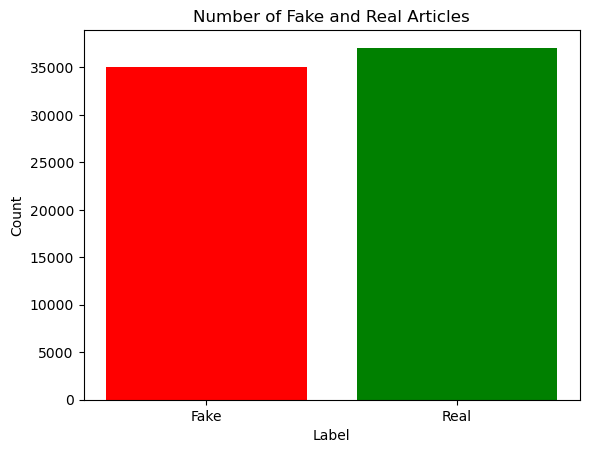

Total Fake Articles: 35028 (48.59%)
Total Real Articles: 37067 (51.41%)


In [42]:
# count occurances of fake and true data and plot
fake_count = df[df['label'] == 0].shape[0]
real_count = df[df['label'] == 1].shape[0]
total_articles = fake_count + real_count

plt.bar(['Fake', 'Real'], [fake_count, real_count], color=['red', 'green'])
plt.title('Number of Fake and Real Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Print totals and percentages
fake_percentage = (fake_count / total_articles) * 100
real_percentage = (real_count / total_articles) * 100
print(f"Total Fake Articles: {fake_count} ({fake_percentage:.2f}%)")
print(f"Total Real Articles: {real_count} ({real_percentage:.2f}%)")

In [43]:
fake_articles = df[df['label'] == 0]
real_articles_sampled = df[df['label'] == 1].sample(n=fake_count, random_state=42)

balanced_df = pd.concat([fake_articles, real_articles_sampled])

# shuffle dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
0    35028
1    35028
Name: count, dtype: int64


In [44]:
combined_data = balanced_df

In [77]:
# copying code from earlier dataset 
combined_data = balanced_df

In [78]:
spacy.cli.download('en_core_web_sm')
NER = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [79]:
# Randomly sample 5000 fake and 5000 true articles
sampled_fake = combined_data[combined_data['label'] == 0].sample(5000, random_state=42)
sampled_true = combined_data[combined_data['label'] == 1].sample(5000, random_state=42)

sampled_data = pd.concat([sampled_fake, sampled_true]).reset_index(drop=True)

In [80]:
# Function to count locations and people
def count_entities(text):
    doc = NER(" ".join(text))
    people = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
    locations = sum(1 for ent in doc.ents if ent.label_ == "GPE")
    return people, locations

entity_counts = sampled_data['text_tokenized_filtered'].apply(count_entities)

sampled_data['person_count'] = [count[0] for count in entity_counts]
sampled_data['location_count'] = [count[1] for count in entity_counts]

sampled_data.head()

,title,text,label,text_tokenized,text_tokenized_filtered,person_count,location_count
0,U.S. Strikes on Syria Put Xi in Tough Position...,BEIJING — The missiles were being prepared ...,0,"[BEIJING, —, The, missiles, were, being, prepa...","[beijing, missiles, prepared, even, two, men, ...",9,58
1,Illegal Immigrant Family Shocked at Immigratio...,The family of an illegal immigrant arrested du...,0,"[The, family, of, an, illegal, immigrant, arre...","[family, illegal, immigrant, arrested, recent,...",10,4
2,Firebombs and Accusations Fly in ‘Ruthless’ El...,"MEXICO CITY — Trailing badly in the polls, ...",0,"[MEXICO, CITY, —, Trailing, badly, in, the, po...","[mexico, city, trailing, badly, polls, electio...",9,7
3,"Iran, Lebanon's Hariri differ on key meeting",BEIRUT (Reuters) - A top Iranian official and ...,0,"[BEIRUT, (, Reuters, ), -, A, top, Iranian, of...","[beirut, reuters, top, iranian, official, leba...",2,24
4,"Russia Deploys Missile, Violating Treaty and C...",WASHINGTON — Russia has secretly deployed a...,0,"[WASHINGTON, —, Russia, has, secretly, deploye...","[washington, russia, secretly, deployed, new, ...",13,28


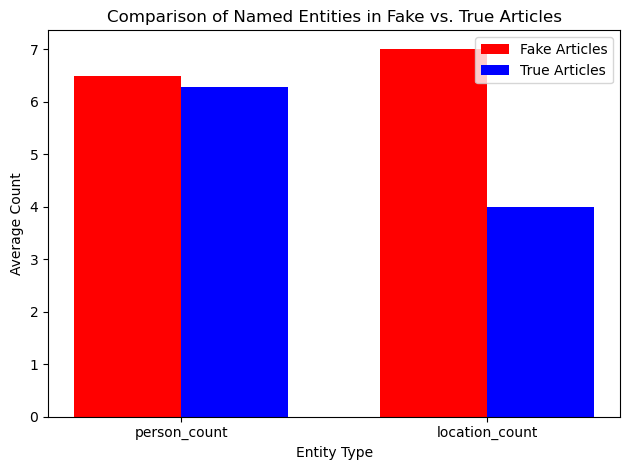

In [81]:
fake_stats = sampled_data[sampled_data['label'] == 0][['person_count', 'location_count']].mean()
true_stats = sampled_data[sampled_data['label'] == 1][['person_count', 'location_count']].mean()

categories = ['person_count', 'location_count']
fake_means = [fake_stats[cat] for cat in categories]
true_means = [true_stats[cat] for cat in categories]


x = np.arange(len(categories))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, fake_means, width, label='Fake Articles', color='red')
ax.bar(x + width/2, true_means, width, label='True Articles', color='blue')
ax.set_xlabel('Entity Type')
ax.set_ylabel('Average Count')
ax.set_title('Comparison of Named Entities in Fake vs. True Articles')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.tight_layout()
plt.show()

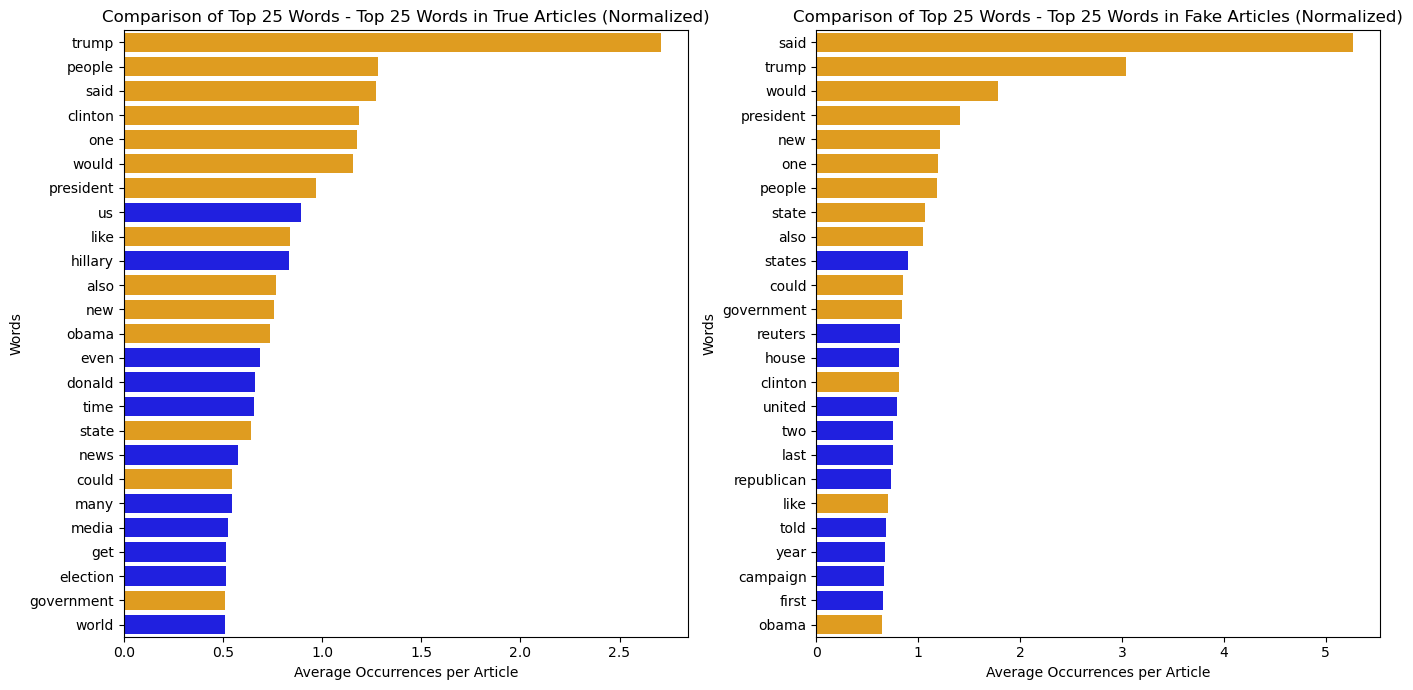

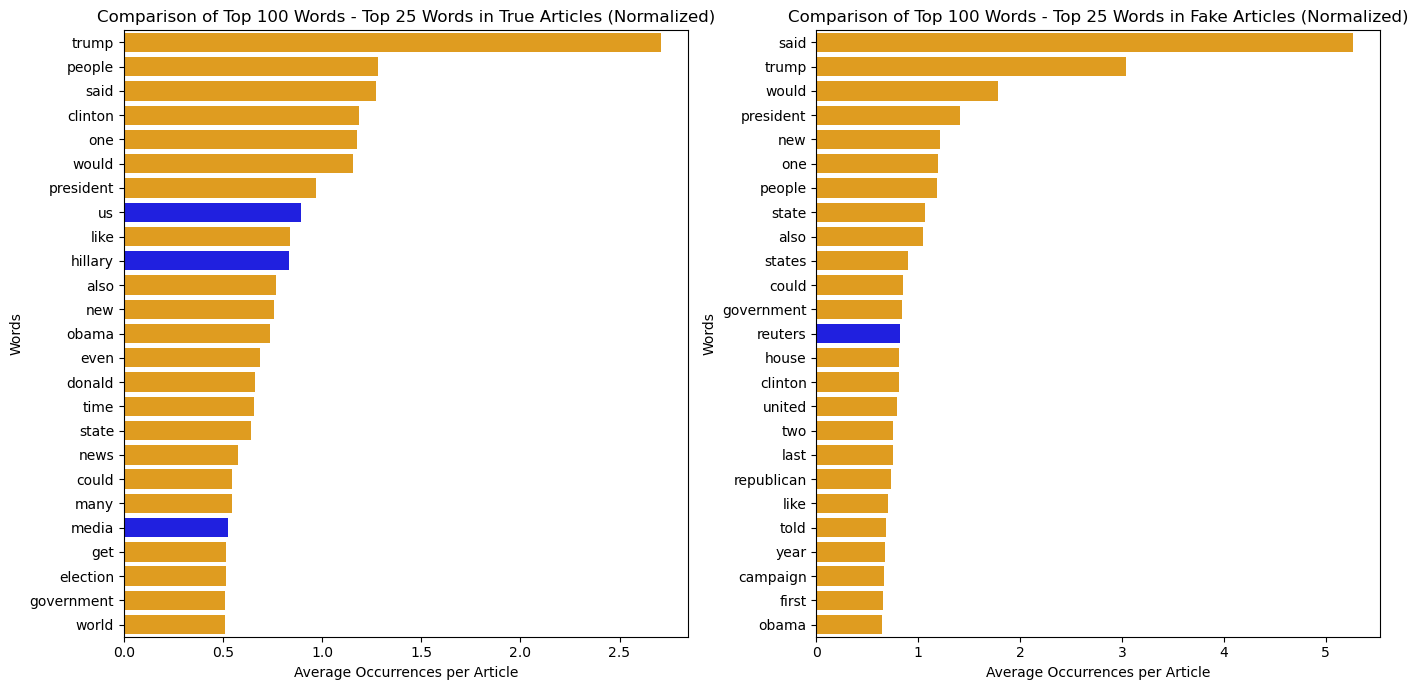

In [82]:
# Separate tokenized words by label then find top 25/top 100. find intersection of sets for overlap and graph
true_words = [word for tokens in combined_data[combined_data['label'] == 1]['text_tokenized_filtered'] for word in tokens]
fake_words = [word for tokens in combined_data[combined_data['label'] == 0]['text_tokenized_filtered'] for word in tokens]

true_word_counts = Counter(true_words)
fake_word_counts = Counter(fake_words)


def graph_common_words(num_depth, base_title):
    true_top_25 = true_word_counts.most_common(num_depth)
    fake_top_25 = fake_word_counts.most_common(num_depth)
    
    true_top_25_dict = dict(true_top_25)
    fake_top_25_dict = dict(fake_top_25)
    
    common_words = set(true_top_25_dict.keys()).intersection(fake_top_25_dict.keys())
    
    def prepare_data_for_plot(top_words, common_words):
        words, counts, colors = [], [], []
        for word, count in top_words:
            words.append(word)
            counts.append(count)
            colors.append('orange' if word in common_words else 'blue')
        return words, counts, colors
    
    # graph by average number of occurances per article
    def average_word_occurrence(word_counts, num_articles):
        return {word: count / num_articles for word, count in word_counts.items()}
    
    true_article_count = len(combined_data[combined_data['label'] == 1])
    fake_article_count = len(combined_data[combined_data['label'] == 0])
    
    true_avg_word_occurrence = average_word_occurrence(true_word_counts, true_article_count)
    fake_avg_word_occurrence = average_word_occurrence(fake_word_counts, fake_article_count)
    
    true_top_25_avg = sorted(true_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    fake_top_25_avg = sorted(fake_avg_word_occurrence.items(), key=lambda x: x[1], reverse=True)[:25]
    
    true_words_avg, true_counts_avg, true_colors = prepare_data_for_plot(true_top_25_avg, common_words)
    fake_words_avg, fake_counts_avg, fake_colors = prepare_data_for_plot(fake_top_25_avg, common_words)
    
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x=true_counts_avg, y=true_words_avg, hue=true_words_avg, palette=true_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in True Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=fake_counts_avg, y=fake_words_avg, hue=fake_words_avg, palette=fake_colors, legend=False)
    plt.title(base_title + ' - Top 25 Words in Fake Articles (Normalized)')
    plt.xlabel('Average Occurrences per Article')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()


graph_common_words(25, "Comparison of Top 25 Words")
graph_common_words(100, "Comparison of Top 100 Words")

# Create Logistic Regression Model

In [45]:
tokenized_texts = combined_data['text_tokenized_filtered']

EMBEDDING_DIM = 100  # size of embeddings
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

def document_embedding(tokens, model):
    """Compute document embedding by averaging word embeddings."""
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

document_embeddings = np.array([document_embedding(doc, w2v_model) for doc in tokenized_texts])

y = combined_data['label'].values
X_train, X_test, y_train, y_test = train_test_split(document_embeddings, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# evaluate
y_pred = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8761775620896375
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6935
           1       0.87      0.88      0.88      7077

    accuracy                           0.88     14012
   macro avg       0.88      0.88      0.88     14012
weighted avg       0.88      0.88      0.88     14012



# Testing model on old datasets

In [46]:
test_embeddings = np.array([document_embedding(tokens, w2v_model) for tokens in test_data['text_tokenized_filtered']])

y_true = test_data['label'].values
y_pred = logistic_model.predict(test_embeddings)

# evaluate
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("Accuracy on the test dataset:", accuracy)
print("\nClassification Report:\n", report)

Accuracy on the test dataset: 0.21689029202841356

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.12      0.13      3164
           1       0.26      0.31      0.29      3171

    accuracy                           0.22      6335
   macro avg       0.21      0.22      0.21      6335
weighted avg       0.21      0.22      0.21      6335

